In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as npimport 
import matplotlib.pyplot as plt

In [6]:
print(torch.__version__)

2.8.0+cu126


In [7]:
torch.manual_seed(7)
np.random.seed(7)

### Model definieren

In [26]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Layer definieren
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, t):
        # Schritt weiter reichen
        x = self.fc1(t)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

In [10]:
T0_true = 4.0
k_true = 0.1

def T_true_fn(t):
    return T0_true * np.exp(-k_true * t)

In [11]:
N_data = 20

t_data = np.sort(np.random.uniform(0.0, 20.0, size=N_data)).astype(np.float32)
y_clean = T_true_fn(t_data).astype(np.float32)


noise_sigma = 0.15
y_noisy = (y_clean + np.random.normal(0.0, noise_sigma, size=N_data)).astype(np.float32)

(20,)
(20,)


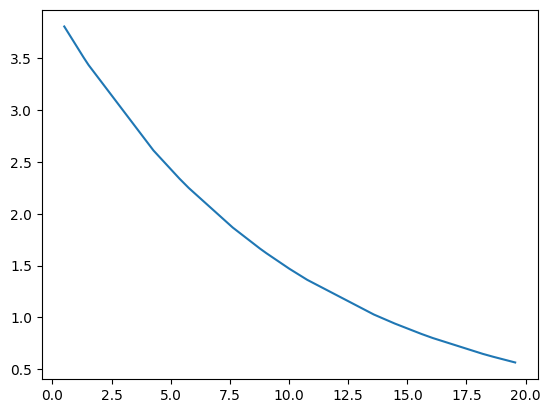

In [18]:
print(t_data.shape)
print(y_clean.shape)

plt.plot(t_data, y_clean)
plt.show()

(20,)
(20,)


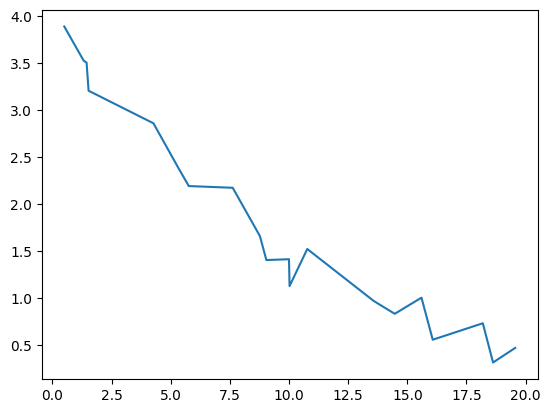

In [19]:
print(t_data.shape)
print(y_noisy.shape)

plt.plot(t_data, y_noisy)
plt.show()

In [21]:
t_data_t = torch.tensor(t_data).reshape(-1,1)
y_noisy_t = torch.tensor(y_noisy).reshape(-1,1)

print(t_data_t.shape)
print(y_noisy_t.shape)

torch.Size([20, 1])
torch.Size([20, 1])


In [23]:
t_grid = np.linspace(0, 20, 200).astype(np.float32)
t_grid_t = torch.tensor(t_grid).reshape(-1,1)

print(t_grid.shape)
print(t_grid_t.shape)

(200,)
torch.Size([200, 1])


In [24]:
def grad_wrt_t(y, t):
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]


In [27]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [30]:
lambda_data = 1.0
lambda_phys = 1.0
lambda_ic = 1.0

N_phys = 48
t_phys_base = torch.linspace(0.0, 20.0, N_phys).reshape(-1,1)
print(t_phys_base.shape)

torch.Size([48, 1])


Die drei Terme können unterschiedliche Größenordnungen haben. Mit 
λ
λ balancierst du:

* Wenn das Modell zu sehr „den Daten hinterherläuft“ und Physik verletzt → λ_phys hoch.

* Wenn es die Physik erfüllt, aber Messpunkte verfehlt → λ_data hoch.

* Wenn T(0) nicht stimmt → λ_ic hoch.

In [35]:
epochs = 1000

for ep in range(epochs):
    pred_data = model(t_data_t)
    loss_data = ((pred_data - y_noisy_t)**2).mean()

    t_phys = (t_phys_base + 0.02*torch.randn_like(t_phys_base)).clamp(0,20)
    t_phys.requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = grad_wrt_t(T_phys, t_phys)
    
    loss_phys = (dT_dt + k_true*T_phys).pow(2).mean()

    t0 = torch.zeros(1,1, requires_grad=True)
    T0_pred = model(t0)
    loss_ic = (T0_pred - torch.tensor([[T0_true]], dtype=T0_pred.dtype)).pow(2).mean()

    loss = lambda_data*loss_data + lambda_phys*loss_phys + lambda_ic*loss_ic

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (ep+1) % 50 == 0:
        print(f"Epoch {ep+1:3d} | Data: {loss_data.item():.4f} | Phys: {loss_phys.item():.4f} | IC: {loss_ic.item():.4f} | Total: {loss.item():.4f}")


Epoch  50 | Data: 0.0275 | Phys: 0.0041 | IC: 0.0000 | Total: 0.0315
Epoch 100 | Data: 0.0270 | Phys: 0.0036 | IC: 0.0000 | Total: 0.0306
Epoch 150 | Data: 0.0267 | Phys: 0.0031 | IC: 0.0000 | Total: 0.0298
Epoch 200 | Data: 0.0265 | Phys: 0.0029 | IC: 0.0000 | Total: 0.0293
Epoch 250 | Data: 0.0263 | Phys: 0.0025 | IC: 0.0000 | Total: 0.0288
Epoch 300 | Data: 0.0262 | Phys: 0.0023 | IC: 0.0000 | Total: 0.0285
Epoch 350 | Data: 0.0261 | Phys: 0.0021 | IC: 0.0000 | Total: 0.0281
Epoch 400 | Data: 0.0260 | Phys: 0.0019 | IC: 0.0000 | Total: 0.0279
Epoch 450 | Data: 0.0259 | Phys: 0.0018 | IC: 0.0000 | Total: 0.0277
Epoch 500 | Data: 0.0259 | Phys: 0.0017 | IC: 0.0000 | Total: 0.0276
Epoch 550 | Data: 0.0259 | Phys: 0.0016 | IC: 0.0000 | Total: 0.0274
Epoch 600 | Data: 0.0258 | Phys: 0.0015 | IC: 0.0000 | Total: 0.0273
Epoch 650 | Data: 0.0258 | Phys: 0.0013 | IC: 0.0000 | Total: 0.0272
Epoch 700 | Data: 0.0258 | Phys: 0.0014 | IC: 0.0000 | Total: 0.0272
Epoch 750 | Data: 0.0258 | Phys: 0

In [36]:
with torch.no_grad():
    pred_grid = model(t_grid_t).squeeze().numpy()

In [37]:
y_true_grid = T_true_fn(t_grid)

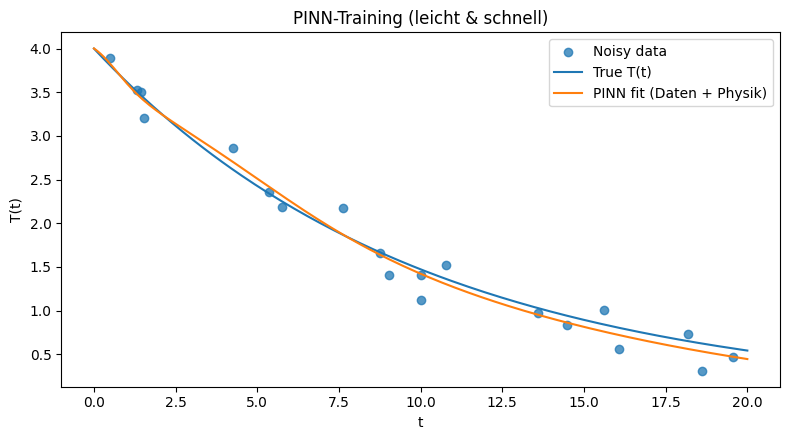

In [38]:
plt.figure(figsize=(8,4.5))
plt.scatter(t_data, y_noisy, label="Noisy data", alpha=0.75)
plt.plot(t_grid, y_true_grid, label="True T(t)")
plt.plot(t_grid, pred_grid, label="PINN fit (Daten + Physik)")
plt.xlabel("t")
plt.ylabel("T(t)")
plt.title("PINN-Training (leicht & schnell)")
plt.legend()
plt.tight_layout()
plt.show()